In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error
from datetime import datetime, timedelta


In [62]:
# Calculate MAPE values
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

In [63]:
# Load the data
data1 = pd.read_csv('C:\\Users\\tejas\\Desktop\\sample_1 daily.csv', parse_dates=['point_timestamp'], index_col='point_timestamp')

# Set the frequency to daily

data1.index = pd.date_range(start=data1.index.min(), end=data1.index.max(), freq='D')

# Remove null values
data1 = data1.dropna()


data1 = data1.drop('Unnamed: 0', axis = 1)


In [64]:
# Arima 
def ARIM(start_date, end_date, data, train_data = data1.iloc[:int(len(data)*0.8)]):
    test_data = data.iloc[int(len(data) * 0.8):] # last 20% of the data as testing data

    # Fit the model
    arima_model = sm.tsa.arima.ARIMA(train_data['point_value'], order=(1,1,1)) # using an autoregressive term of order 1, a differencing term of order 1, and a moving average term of order 1
    arima_model = arima_model.fit()

    # Generate predictions 
    
    arima_pred = arima_model.predict(start=start_date, end=end_date, dynamic=False)
#     arima_pred = arima_model.forecast(len(test_data))

    # Calculate mean absolute percentage error (MAPE)
    arima_mape = calculate_mape(test_data['point_value'], arima_pred)
    return arima_mape
#     print('MAPE:', arima_mape)

In [65]:
# SARIMA
def SARIMA(data, train_data = data1.iloc[:int(len(data)*0.8)]):
    test_data = data.iloc[int(len(data) * 0.8):] # last 20% of the data as testing data

    # Fit the SARIMA model
    sarima_model = sm.tsa.statespace.SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(0, 0, 0, 7)) # 7 indicates that there is a daily seasonality in the data
    sarima_model = sarima_model.fit()

    # Make predictions
    sarima_pred = sarima_model.forecast(len(test_data))

    # Calculate MAPE
    sarima_mape = calculate_mape(test_data['point_value'], sarima_pred)
    return sarima_mape
#     print('MAPE:', sarima_mape)

In [66]:
# XGBoost
def XGBoost(data, train_data = data1.iloc[:int(len(data)*0.8)]):
    test_data = data[int(len(data) * 0.8):] # last 20% of the data as testing data

    # Define the features and target variable
    features = ['point_value']
    target = 'point_value'

    # Train the XGBoost model
    xgb_model = xgb.XGBRegressor()
    xgb_model.fit(train_data[features], train_data[target])

    # Make predictions on the test set
    xgb_preds = xgb_model.predict(test_data[features])

    # Calculate MAPE
    xgb_mape = calculate_mape(test_data[target], xgb_preds)
    return xgb_mape
#     print('MAPE:', xgb_mape)

In [67]:
# ETS
def ETS(data, train_data = data1.iloc[:int(len(data)*0.8)]):
    test_data = data[int(len(data) * 0.8):] # last 20% of the data as testing data

    # Create and fit the ETS model
    ets_model = ETSModel(train_data['point_value'].astype(float), error='add', trend='add', seasonal='add', seasonal_periods=7)
    ets_model = ets_model.fit()


    # Make predictions on the test set
    ets_pred = ets_model.predict(start=test_data.index[0], end=test_data.index[-1])

    # Calculate MAPE
    ets_mape = calculate_mape(test_data['point_value'], ets_pred)
    return ets_mape
#     print('MAPE:', ets_mape)

In [83]:
# Load the data which we will use to train the model with
data2 = pd.read_csv('C:\\Users\\tejas\\Desktop\\sample_2 daily.csv', parse_dates=['point_timestamp'], index_col='point_timestamp')
data3 = pd.read_csv('C:\\Users\\tejas\\Desktop\\sample_3 daily.csv', parse_dates=['point_timestamp'], index_col='point_timestamp')
data4 = pd.read_csv('C:\\Users\\tejas\\Desktop\\sample_4 daily.csv', parse_dates=['point_timestamp'], index_col='point_timestamp')
data5 = pd.read_csv('C:\\Users\\tejas\\Desktop\\sample_5 daily.csv', parse_dates=['point_timestamp'], index_col='point_timestamp')

# Set their frequencies to Daily
data2.index = pd.date_range(start=data2.index.min(), end=data2.index.max(), freq='D')
data3.index = pd.date_range(start=data3.index.min(), end=data3.index.max(), freq='D')
data4.index = pd.date_range(start=data4.index.min(), end=data4.index.max(), freq='D')
data5.index = pd.date_range(start=data5.index.min(), end=data5.index.max(), freq='D')

# Remove null values
data2 = data2.dropna()
data3 = data3.dropna()
data4 = data4.dropna()
data5 = data5.dropna()

data2 = data2.drop('Unnamed: 0', axis = 1)
data3 = data3.drop('Unnamed: 0', axis = 1)
data4 = data4.drop('Unnamed: 0', axis = 1)
data5 = data5.drop('Unnamed: 0', axis = 1)
data5

,point_value
2021-09-02,128
2021-09-03,111
2021-09-04,93
2021-09-05,77
2021-09-06,113
...,...
2023-01-14,1
2023-01-15,2
2023-01-16,1
2023-01-17,0


In [107]:
# Selection algorithm
# I am running all the above Time Series models for multiple datasets and storing the Least MAPE values, the model which 
# gives the least MAPE Values most number of times will be stored and then the new model used to train will also be added 
# to the training data
train_data2 = data2.iloc[:int(len(data2)*0.8)]
train_data3 = data3.iloc[:int(len(data3)*0.8)]
train_data4 = data4.iloc[:int(len(data4)*0.8)]
train_data5 = data5.iloc[:int(len(data5)*0.8)]
best_model_count = {"ARIMA": 0, "SARIMA": 0, "XGBoost": 0, "ETS": 0}
train = [train_data2, train_data3, train_data4, train_data5]
dat = [data2, data3, data4, data5]
def select(data):   
    for i in range(len(train)):
        # Choose the model with the lowest MAPE
        if i == 0:
            arima_mape = ARIM('2021-10-16','2023-02-01', dat[i], train[i])
        elif i == 1:
            arima_mape = ARIM('2021-01-02','2021-09-19', dat[i], train[i])
        elif i == 2:
            arima_mape = ARIM('2022-02-21','2023-01-27',dat[i], train[i])
        elif i == 3:
            arima_mape = ARIM('2021-09-02','2023-01-18', dat[i], train[i])
        sarima_mape = SARIMA(dat[i], train[i])
        xgb_mape = XGBoost(dat[i], train[i])
        ets_mape = ETS(dat[i], train[i])
        mape_values = {"ARIMA": arima_mape, "SARIMA": sarima_mape, "XGBoost": xgb_mape, "ETS": ets_mape}
        best_model = min(mape_values, key=mape_values.get)
        best_model_count[best_model] += 1
    if data not in dat:
        dat.append(data)
        train.append(data.iloc[:int(len(data)*0.8)])
    

In [108]:
# algorithm to use selection algorithm to check what model to use
def select(start_date, end_date, data):
    select(data)
    best_model = min(best_model_count, key=mape_values.get)
    return best_model

# print("The best model is: ", best_model)


In [109]:
 # Predict for test data using Best model and plot

def prediction(start_date, end_date, best_model, data) :
    train_data = data.iloc[:int(len(data)*0.8)] #First 80 % is train data
    test_data = data[int(len(data) * 0.8):] # Last 20% is test

    # test_train_split can also be used

    if best_model == 'ARIMA':
        arima_model = sm.tsa.arima.ARIMA(train_data['point_value'], order=(1,1,1)) # using an autoregressive term of order 1, a differencing term of order 1, and a moving average term of order 1
        arima_model = arima_model.fit()

        # Generate predictions 
        
        pred = arima_model.predict(start=start_date, end=end_date, dynamic=False)
#         pred = arima_model.forecast(len(test_data))

        # Calculate mean absolute percentage error (MAPE)
        mape = calculate_mape(test_data['point_value'], pred)
#         print('MAPE:', mape)
    elif best_model == 'SARIMA':
        # Fit the SARIMA model
        sarima_model = sm.tsa.statespace.SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(0, 0, 0, 7)) # 7 indicates that there is a daily seasonality in the data
        sarima_model = sarima_model.fit()

        # Make predictions
        pred = sarima_model.forecast(len(test_data))

        # Calculate MAPE
        mape = calculate_mape(test_data['point_value'], pred)
#         print('MAPE:', mape)
    elif best_model == 'XGBoost':
        # Define the features and target variable
        features = ['point_value']
        target = 'point_value'

        # Train the XGBoost model
        xgb_model = xgb.XGBRegressor()
        xgb_model.fit(train_data[features], train_data[target])

        # Make predictions on the test set
        pred = xgb_model.predict(test_data[features])

        # Calculate MAPE
        mape = calculate_mape(test_data[target], pred)
#         print('MAPE:', mape)
    elif best_model == 'ETS':
        # Create and fit the ETS model
        ets_model = ETSModel(train_data['point_value'].astype(float), error='add', trend='add', seasonal='add', seasonal_periods=7)
        ets_model = ets_model.fit()


        # Make predictions on the test set
        pred = ets_model.predict(start=test_data.index[0], end=test_data.index[-1])

        # Calculate MAPE
        mape = calculate_mape(test_data['point_value'], pred)
#         print('MAPE:', mape)
#     print(pred)
    df = data[int(len(data) * 0.75):]
    plt.plot(df.index, df.values, label='actual')
    plt.plot(test_data.index, pred, label='predicted')
    plt.legend()
    plt.show()
    return mape


In [110]:
# A function which will get the response body for the fastapi
def predict1(start_date, end_date, best_model, data):
    test_data = data # Data we send in the function is data we want

    # test_train_split can also be used

    if best_model == 'ARIMA':
        arima_model = sm.tsa.arima.ARIMA(train_data['point_value'], order=(1,1,1)) # using an autoregressive term of order 1, a differencing term of order 1, and a moving average term of order 1
        arima_model = arima_model.fit()

        # Generate predictions 
        
        pred = arima_model.predict(start=start_date, end=end_date, dynamic=False)
#         pred = arima_model.forecast(len(test_data))

        # Calculate mean absolute percentage error (MAPE)
        mape = calculate_mape(test_data['point_value'], pred)
#         print('MAPE:', mape)
    elif best_model == 'SARIMA':
        # Fit the SARIMA model
        sarima_model = sm.tsa.statespace.SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(0, 0, 0, 7)) # 7 indicates that there is a daily seasonality in the data
        sarima_model = sarima_model.fit()

        # Make predictions
        pred = sarima_model.forecast(len(test_data))

        # Calculate MAPE
        mape = calculate_mape(test_data['point_value'], pred)
#         print('MAPE:', mape)
    elif best_model == 'XGBoost':
        # Define the features and target variable
        features = ['point_value']
        target = 'point_value'

        # Train the XGBoost model
        xgb_model = xgb.XGBRegressor()
        xgb_model.fit(train_data[features], train_data[target])

        # Make predictions on the test set
        pred = xgb_model.predict(test_data[features])

        # Calculate MAPE
        mape = calculate_mape(test_data[target], pred)
#         print('MAPE:', mape)
    elif best_model == 'ETS':
        # Create and fit the ETS model
        ets_model = ETSModel(train_data['point_value'].astype(float), error='add', trend='add', seasonal='add', seasonal_periods=7)
        ets_model = ets_model.fit()


        # Make predictions on the test set
        pred = ets_model.predict(start=test_data.index[0], end=test_data.index[-1])

        # Calculate MAPE
        mape = calculate_mape(test_data['point_value'], pred)
#         print('MAPE:', mape)
#     print(pred)
    
    return mape, pred 


In [111]:
# This is the connecter function which gives me all the desired outputs needed for FAST API
def connect(start_date, end_date, period):
#     Check whether the data has periods to predict further
    if period > 0:
        end_date = datetime.strptime(end_date, '%Y-%m-%d')
        end_date = end_date + timedelta(days=period)
        end_date = end_date.strftime('%Y-%m-%d')
    data1 = data.loc[start_date:end_date]
    val = data1['point_value'].tolist()
    best = selection(start_date, end_date, data1)
    mape, predi = predict1(start_date, end_date, best, data1)
    predi = list(predi)
    ind1 = data1.index.tolist()
    ind = []
#     Convertin datetime object to string
    for i in ind1:
        temp = i.strftime('%Y-%m-%d %H:%M:%S')
        ind.append(temp)
    return best, mape, predi, ind, val
#     print(ind)

In [112]:
connect('2021-07-24', '2021-07-26',0)

('XGBoost',
 0.0003848757062639509,
 [7.000006, 7.000006, 7.999922],
 ['2021-07-24 00:00:00', '2021-07-25 00:00:00', '2021-07-26 00:00:00'],
 [7, 7, 8])

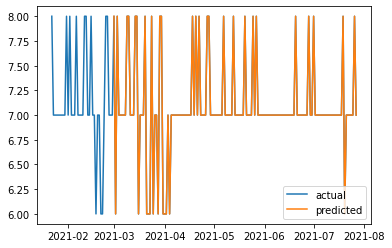

XGBoost 0.00035922799334430156


In [113]:
b = selection('2019-07-17','2021-07-27',data)
ma = prediction('2019-07-17', '2021-07-27', b, data)
print(b,ma)